## TCGA Analysis
- Deconvolve into pigmentation group to analyze cofounding factors.

#### Statistical significante of ROC
- DeLong test for statistical significance of ROCAUC [link](https://www.jstor.org/stable/2531595?seq=1)
- DeLong test in Python [link](https://biasedml.com/roc-comparison/)
- Bootstrapping ROC for estimating error [StackOverflow](https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals).

In [1]:
import pandas as pd
import numpy as np
import os
import glob

import re
from tommy_library import *

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from tqdm import tqdm

In [2]:
'Load metadata'
data_fld = '../data'
sub_fld = os.path.join(data_fld, 'TCGA_data')
path = os.path.join(sub_fld, 'tcga_wsi_meta.csv')
df_wsi = pd.read_csv(path, index_col=0)
path = os.path.join(sub_fld, 'tcga_tile_meta.csv')
df_tile = pd.read_csv(path)

'Load predictions post-inference'
path = os.path.join(sub_fld, '0107_pred_TCGA_2.csv')
df_tst = pd.read_csv(path, index_col=0)
# assert len(df_tile) == len(df_tst)  # i removed low quality WSI 

In [3]:
path = os.path.join(sub_fld, 'Alkallas_RNAsign_plus_CNA_of_interest_and_pigmentation.txt')
df_pig = pd.read_csv(path, sep='\t')

In [4]:
df_pig.pigment_score.value_counts()

0.0    197
1.0     79
2.0     31
3.0     22
Name: pigment_score, dtype: int64

In [5]:
'Compute predictions for WSIs (cutoff-dependent)'
entropy_cutoff = .2

# annotate uncertain tiles
mask = df_tst.tile_entropy > entropy_cutoff
df_tst['uncertain'] = False
df_tst['uncertain'] = mask

# remove uncertain tiles
mask = df_tst.uncertain == False
df_tst = df_tst[mask].copy()

# compute prediction on tiles
df_tst['APC_prob'] = (df_tst.CBTPA + df_tst.CBTA)  
ox_mask = df_tst.rna_subtype == 'OxPhos'
df_tst['APC_BC_OxPhos'] = df_tst.BetaCAT | df_tst.APC | ox_mask

# get prediction for WSIs
num_tiles = df_tst.groupby('wsi_id').count().x_tile_coord
df_wsi = df_tst.groupby('wsi_id').sum()
df_wsi['APC_prob_norm'] = df_wsi['APC_prob'] / num_tiles

df_wsi['APC'] = df_wsi.APC != 0
df_wsi['APC_BC'] = df_wsi.APC_BC != 0
df_wsi['APC_OxPhos'] = df_wsi.APC_OxPhos != 0
df_wsi['OxPhos'] = df_wsi.OxPhos != 0
df_wsi['APC_BC_OxPhos'] = df_wsi.APC_BC_OxPhos != 0

In [6]:
'Merge via DONOR ID'
lol = lambda x : '-'.join([x[0], x[1], x[2]])
df_wsi['clinical_donor_id'] = df_wsi.index.str.split('-').map(lol).values
df_wsi = df_wsi.merge(
    df_pig[['clinical_donor_id', 'pigment_score']], 
    on='clinical_donor_id', 
    validate='many_to_one'
)

In [7]:
roc_auc_score(df_tst['APC_BC_OxPhos'], df_tst['APC_prob'])

0.6165100325155615

In [8]:
roc_auc_score(df_wsi['APC_BC_OxPhos'], df_wsi['APC_prob_norm'])

0.6607921045885672

In [9]:
roc_auc_score(df_wsi['OxPhos'], df_wsi['APC_prob_norm'])

0.7465391621129326

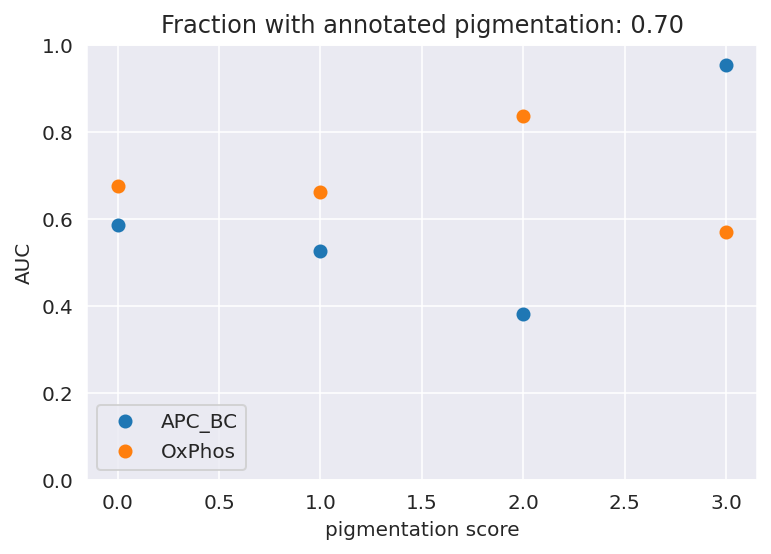

In [12]:
import seaborn as sns
sns.set_style('darkgrid')
scores = [0, 1, 2, 3]
apc_aucs = []
apc_bc_aucs = []
apc_bcox_aucs = []
apc_aox_aucs = []
apc_ox_aucs = []
for score in scores:
    mask = df_wsi.pigment_score == score
    auc = roc_auc_score(df_wsi[mask]['APC'], df_wsi[mask]['APC_prob_norm'])
    apc_aucs.append(auc)
    auc = roc_auc_score(df_wsi[mask]['APC_BC'], df_wsi[mask]['APC_prob_norm'])
    apc_bc_aucs.append(auc)
    auc = roc_auc_score(df_wsi[mask]['APC_OxPhos'], df_wsi[mask]['APC_prob_norm'])
    apc_aox_aucs.append(auc)
    auc = roc_auc_score(df_wsi[mask]['APC_BC_OxPhos'], df_wsi[mask]['APC_prob_norm'])
    apc_bcox_aucs.append(auc)
    auc = roc_auc_score(df_wsi[mask]['OxPhos'], df_wsi[mask]['APC_prob_norm'])
    apc_ox_aucs.append(auc)
pct = 1 - (df_wsi.pigment_score.isna().sum() / len(df_wsi))
plt.title('Fraction with annotated pigmentation: {:.2f}'.format(pct))
plt.ylim(0, 1)
plt.xlabel('pigmentation score')
plt.ylabel('AUC')
# plt.plot(scores, apc_aucs, 'o', label='APC');
plt.plot(scores, apc_bc_aucs, 'o', label='APC_BC');
plt.plot(scores, apc_ox_aucs, 'o', label='OxPhos');
# plt.plot(scores, apc_ox_aucs, 'o', label='APC_OxPh');
# plt.plot(scores, apc_bcox_aucs, 'o', label='APC_BC_OxPh');
plt.legend(loc='lower left');
plt.savefig('../results/pigscore_vs_auc.pdf');